# **Melanoma Detection Assignment**

## **Problem statement:**

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

- Actinic keratosis
- Basal cell carcinoma
- Dermatofibroma
- Melanoma
- Nevus
- Pigmented benign keratosis
- Seborrheic keratosis
- Squamous cell carcinoma
- Vascular lesion

Build a multiclass classification model using a custom convolutional neural network in TensorFlow.

## **Importing Libraries**

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Suppress tensorflow warnings. Only log the errors
import logging
tf.get_logger().setLevel(logging.ERROR)


## **Data Reading/Data Understanding**

##### **Mount Google Drive to fetch dataset**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### **Unzip the dataset zip file**

In [3]:
#unzip the dataset
!unzip /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment.zip -d /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/

Archive:  /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment.zip
  inflating: /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration

## **Dataset creation**

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [6]:
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118


In [7]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [11]:
# Listing out all the classes of skin cancer and store them in a list.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## **Dataset visualisation**

Visualize one instance of all the nine classes present in the dataset

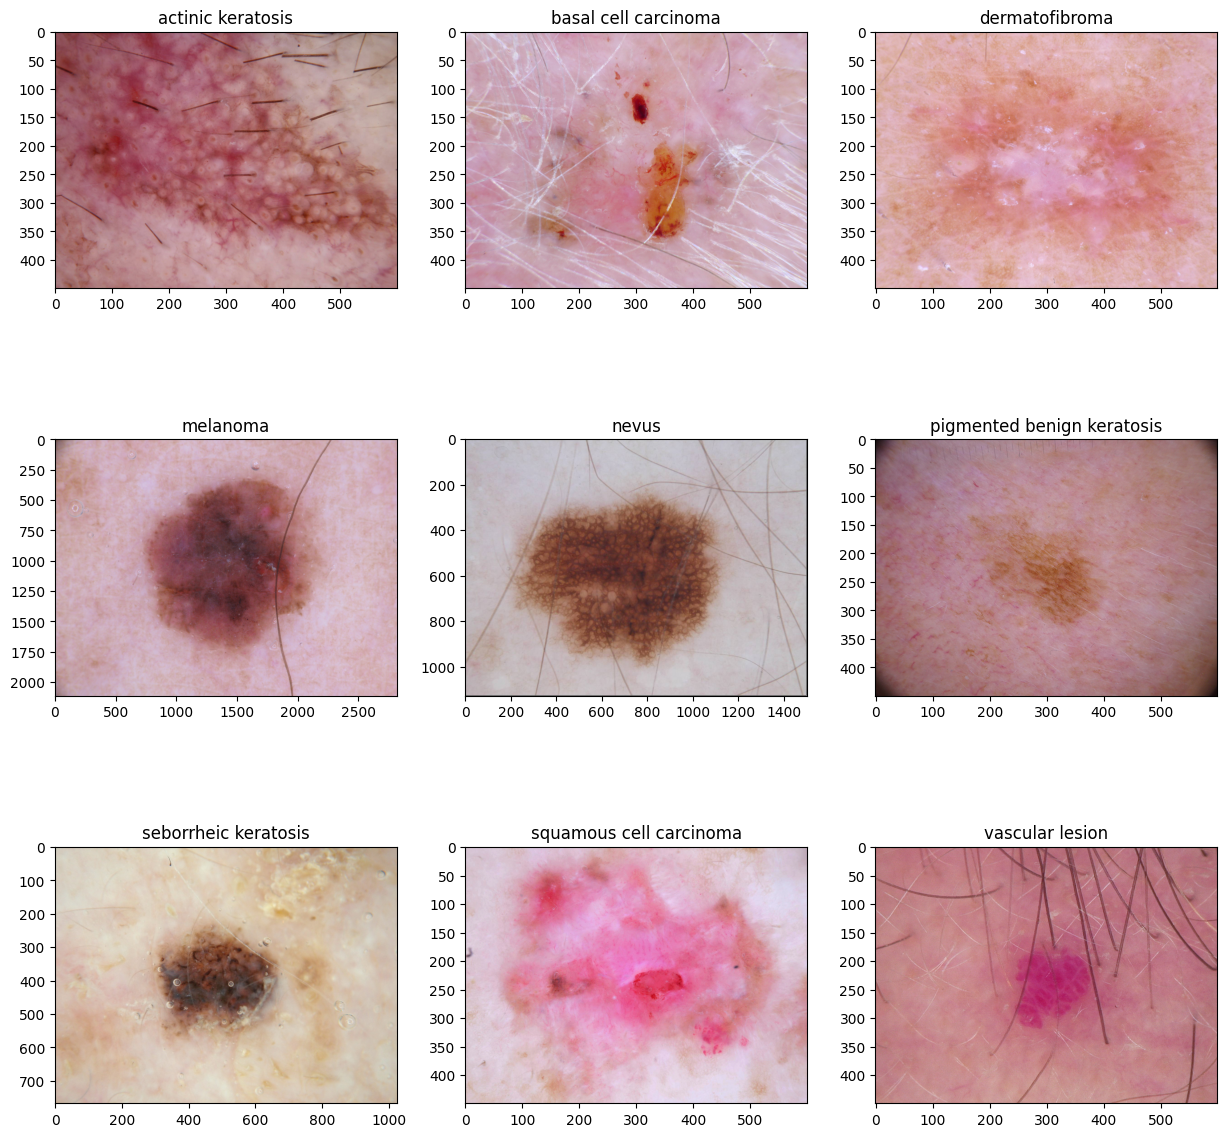

In [12]:
### visualize one instance of all the nine classes present in the dataset
plt.figure(figsize=(15,15))
for i in range(len(class_names)):
  plt.subplot(3,3,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[0]))
  plt.title(class_names[i])
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


## **Model Building & training**
Creating a CNN model, which can accurately detect 9 classes present in the dataset. Using `layers.experimental.preprocessing.Rescaling` to normalize pixel values between `(0,1)`. The RGB channel values are in the `[0, 255]` range.

- Here, it is good to standardize values to be in the `[0, 1]`.

- Choosing an appropriate optimiser and loss function for model training

- Training the model for `~20 epochs`

- Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [14]:
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [15]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 128)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 259200)            0

In [16]:
# Training the model
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
56/56 [==============================] - 355s 6s/step - loss: 2.5304 - accuracy: 0.2020 - val_loss: 1.8837 - val_accuracy: 0.2953
Epoch 2/20
56/56 [==============================] - 309s 6s/step - loss: 1.7193 - accuracy: 0.3705 - val_loss: 1.5301 - val_accuracy: 0.3960
Epoch 3/20
56/56 [==============================] - 317s 6s/step - loss: 1.4431 - accuracy: 0.4866 - val_loss: 1.4765 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 308s 6s/step - loss: 1.3428 - accuracy: 0.5312 - val_loss: 1.4467 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 319s 6s/step - loss: 1.2243 - accuracy: 0.5703 - val_loss: 1.3872 - val_accuracy: 0.5235
Epoch 6/20
56/56 [==============================] - 310s 6s/step - loss: 1.0779 - accuracy: 0.6161 - val_loss: 1.5098 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 311s 6s/step - loss: 0.9745 - accuracy: 0.6535 - val_loss: 1.4498 - val_accuracy: 0.5481
Epoch 8/20
56

In [17]:
#Method to visualize the training results

def visualize_cnn(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(12, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='upper left')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper center')
  plt.title('Training and Validation Loss')
  plt.show()

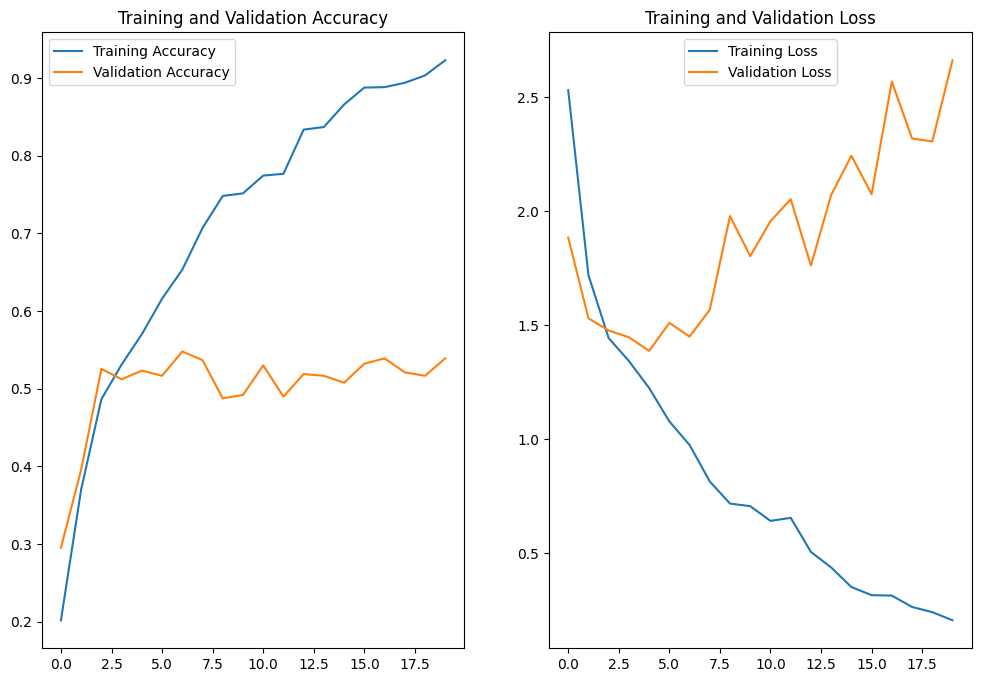

In [18]:
#visualize the training results
visualize_cnn(history, 20)

***Observations:***

- As the training accuracy increases linearly over time, where as the validation accuracy increases to a max value of 50-55% and then stalls.
- As the training loss dereases with epochs the validation loss increases.
- The difference in accuracy between training and validation accuracy is noticeable which is a sign of overfitting and needs tuning.

## **Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting**

Image data augmentation is a technique that can be used to artificially expand the size of a training dataset by creating modified versions of images in the dataset.
This helps expose the model to more aspects of the data and generalize better.

For our model, looks like the training data is insufficient. So, let's try to perform some data augmentation strategy to come up with a bigger dataset

In [ ]:
#Performing data augmentation on the training dataset
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

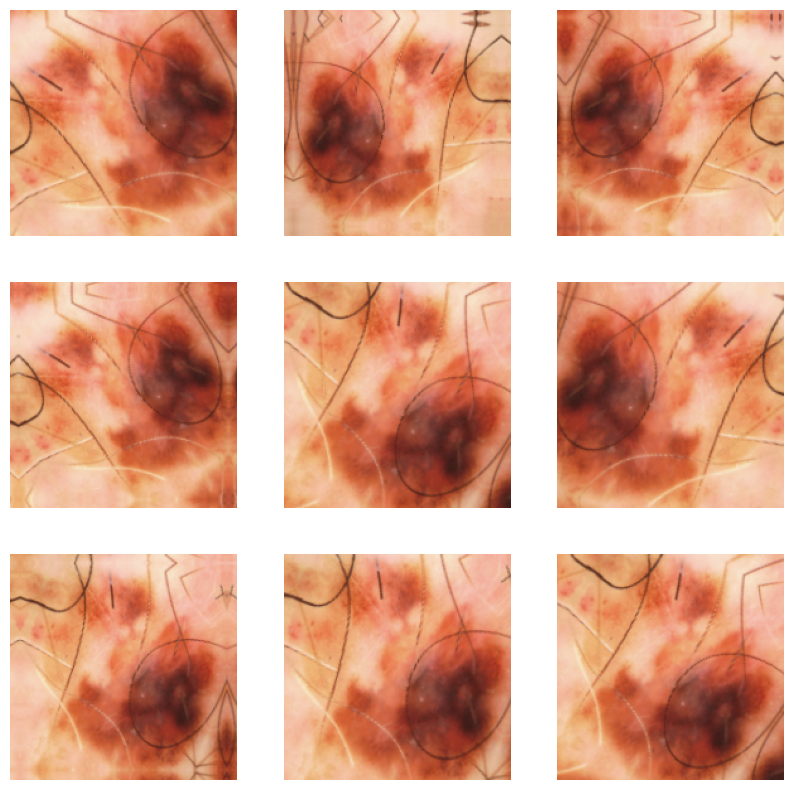

In [ ]:
# visualizing the augmentation strategy for one instance of a training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[1].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# CNN Model with data augmentation

model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

model.add(data_augmentation)

model.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [ ]:
# Compiling the model with data augmentation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

In [ ]:
# Training the model 2nd time with augmentation applied with 20 epochs
history = model.fit( train_ds, validation_data=val_ds, epochs=20 )

Epoch 1/20
56/56 [==============================] - 190s 3s/step - loss: 1.9767 - accuracy: 0.2779 - val_loss: 1.6677 - val_accuracy: 0.4183
Epoch 2/20
56/56 [==============================] - 195s 3s/step - loss: 1.6004 - accuracy: 0.4208 - val_loss: 1.4445 - val_accuracy: 0.5101
Epoch 3/20
56/56 [==============================] - 194s 3s/step - loss: 1.4586 - accuracy: 0.4821 - val_loss: 1.4477 - val_accuracy: 0.5235
Epoch 4/20
56/56 [==============================] - 193s 3s/step - loss: 1.4005 - accuracy: 0.5078 - val_loss: 1.3413 - val_accuracy: 0.5257
Epoch 5/20
56/56 [==============================] - 191s 3s/step - loss: 1.3597 - accuracy: 0.5257 - val_loss: 1.3704 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 182s 3s/step - loss: 1.3674 - accuracy: 0.5084 - val_loss: 1.3668 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 193s 3s/step - loss: 1.2866 - accuracy: 0.5435 - val_loss: 1.3506 - val_accuracy: 0.5235
Epoch 8/20
56

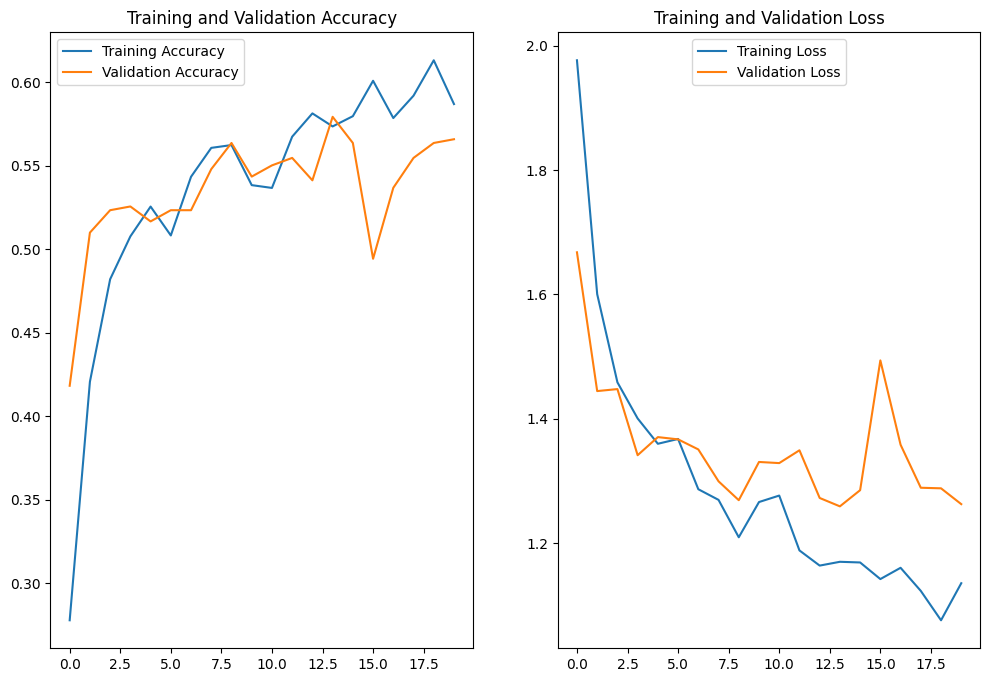

In [ ]:
# Visualize the results of our model after the data augmentation
visualize_cnn(history, 20)

***Observation:***

- the gap between the training accuracy and the validation accuracy is much less now when compared to the initial model.
- The same can be observed with the training loss and the validation loss.
- The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around 55% accuracy on the validation set.
- Overfitting of the model is greatly reduced when compared to the initial model but the overall accuracy isn't really great.

## **Class Distribution**

Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others.

Let's check the class distribution to see if all the classes(cancer types) are equally distributed

In [19]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


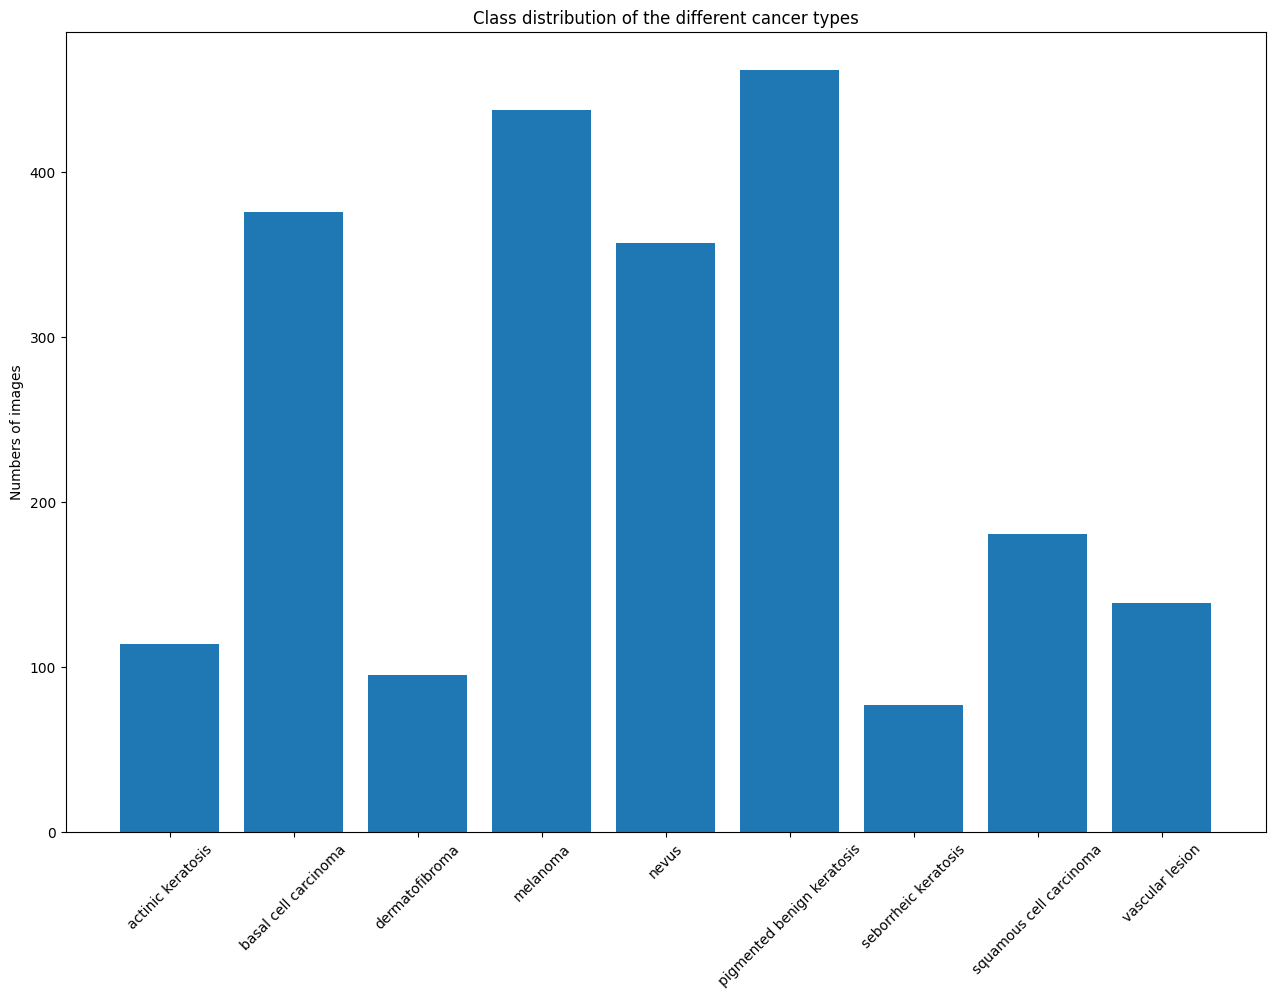

In [20]:
#plot the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types')
plt.xticks(rotation=45)
plt.show()

***Observation:***

- Class imbalance is observed. It can be seen that some classes have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality.

- The class seborrheic keratosis has the least number of samples with just 77 images.

- The class pigmented benign keratosis has the highest number of samples with 462 images.

In [22]:
# To rectify this class imbalance, Augmentor library can be used to artificially generate newer samples.
#Install Augmentor
!pip install Augmentor

In [23]:
import Augmentor

In [24]:
path_to_training_dataset="/content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA359FA9990>: 100%|██████████| 500/500 [00:35<00:00, 14.24 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA36A34FDC0>: 100%|██████████| 500/500 [00:27<00:00, 17.87 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA36B47FE50>: 100%|██████████| 500/500 [00:27<00:00, 17.91 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x7BA36A39BF10>: 100%|██████████| 500/500 [02:18<00:00,  3.61 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x7BA37C185450>: 100%|██████████| 500/500 [01:56<00:00,  4.27 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7BA36A399840>: 100%|██████████| 500/500 [00:27<00:00, 17.87 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7BA36B6B3460>: 100%|██████████| 500/500 [00:57<00:00,  8.63 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA36B42F520>: 100%|██████████| 500/500 [00:25<00:00, 19.35 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7BA36A3991B0>: 100%|██████████| 500/500 [00:27<00:00, 17.89 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Let's take a look at total count of augmented images.

In [25]:
# Newly generated images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Colab_notebooks/Melanoma_detection/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print("Newly generated images with the Augmentor library:", image_count_train)

Newly generated images with the Augmentor library: 4500


Let's see the distribution of augmented data after adding new images to the original training data.

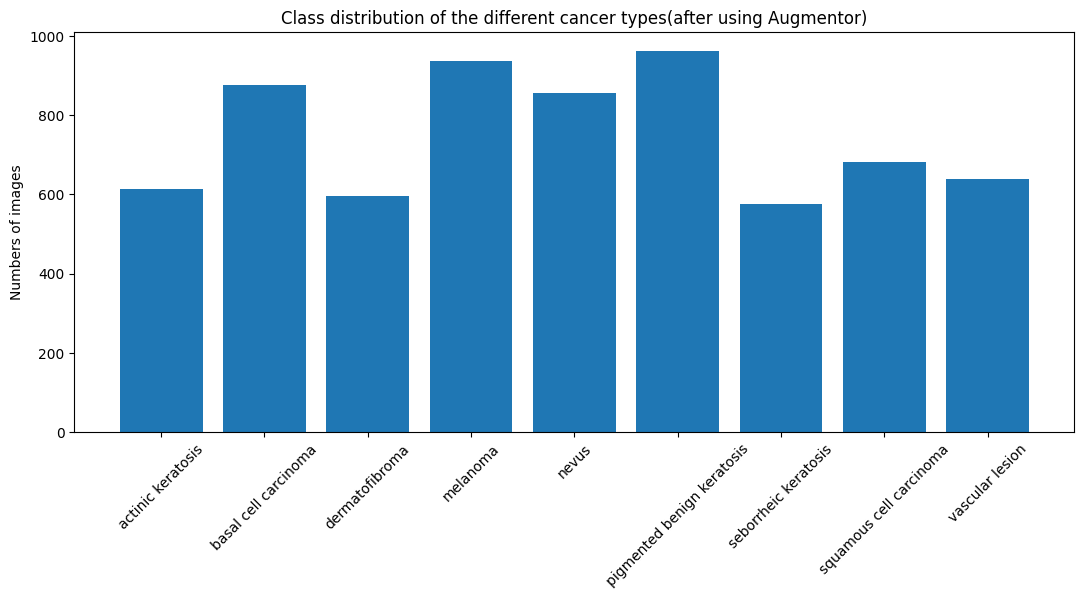

In [26]:
#plot the images to check if all the cancer types are equally distributed
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0,0,1,1])
x=[]
y=[]
for i in range(len(class_names)):
  x.append(class_names[i])
  y.append(len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))) + len(list(data_dir_train.glob(class_names[i]+'/output/*.jpg'))))

ax.bar(x,y)
ax.set_ylabel('Numbers of images')
ax.set_title('Class distribution of the different cancer types(after using Augmentor)')
plt.xticks(rotation=45)
plt.show()

***Observation:***

- 500 images are added to all the classes to maintain some class balance.
- Now there are enough samples to analyze our model.

## creating a training and validation dataset with new samples

In [27]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [28]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Model Building & training on the rectified class imbalance data

- Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between `(0,1)`.

- Choosing an appropriate optimiser and loss function for model training
Training the model for `~30 epochs.`

- Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.



In [30]:
# CNN Model on the rectified class imbalance data created using Augmentor
model=models.Sequential()

model.add(layers.Rescaling(scale=1./255,input_shape=(img_height,img_width,3)))

model.add(layers.Conv2D(32,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))

model.add(layers.Dropout(0.25))

model.add(layers.Dense(len(class_names),activation='softmax'))

In [31]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [32]:
# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 128)      

In [33]:
# Training the model
history = model.fit( train_ds, validation_data=val_ds, epochs=30 )

Epoch 1/30
169/169 [==============================] - 527s 3s/step - loss: 1.9958 - accuracy: 0.2385 - val_loss: 1.4752 - val_accuracy: 0.4343
Epoch 2/30
169/169 [==============================] - 477s 3s/step - loss: 1.5016 - accuracy: 0.4408 - val_loss: 1.3229 - val_accuracy: 0.5145
Epoch 3/30
169/169 [==============================] - 492s 3s/step - loss: 1.3126 - accuracy: 0.5019 - val_loss: 1.2193 - val_accuracy: 0.5457
Epoch 4/30
169/169 [==============================] - 490s 3s/step - loss: 1.1580 - accuracy: 0.5679 - val_loss: 0.9993 - val_accuracy: 0.6295
Epoch 5/30
169/169 [==============================] - 485s 3s/step - loss: 0.9940 - accuracy: 0.6348 - val_loss: 0.9721 - val_accuracy: 0.6333
Epoch 6/30
169/169 [==============================] - 486s 3s/step - loss: 0.8420 - accuracy: 0.7009 - val_loss: 0.8254 - val_accuracy: 0.6956
Epoch 7/30
169/169 [==============================] - 484s 3s/step - loss: 0.7102 - accuracy: 0.7444 - val_loss: 0.7596 - val_accuracy: 0.7223

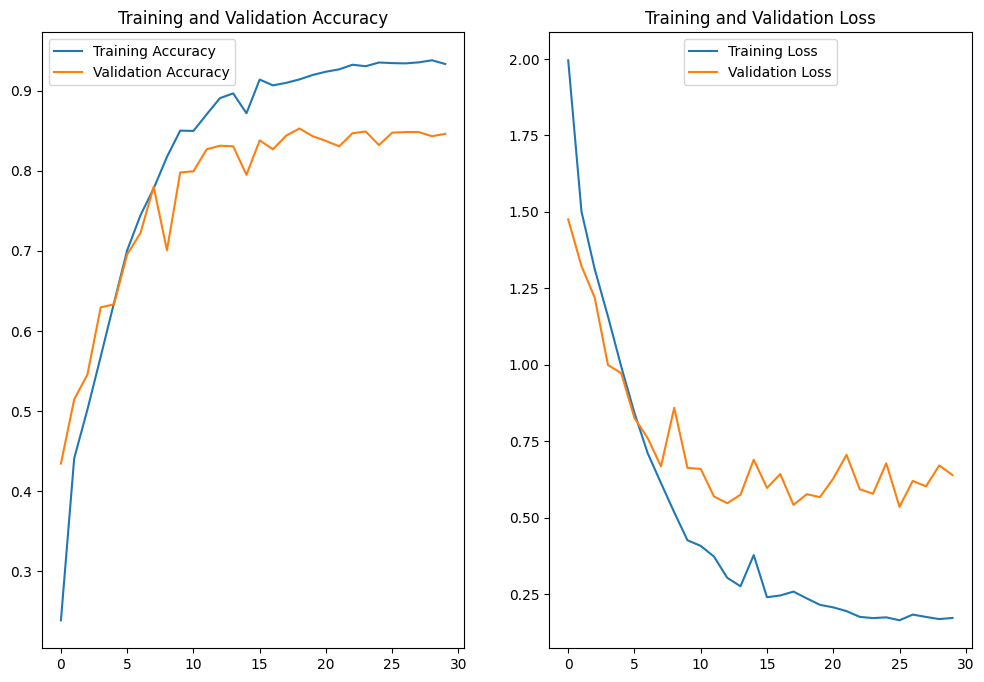

In [35]:
visualize_cnn(history,30)

***Observations:***
- As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.
- As the training loss decreases with epochs the validation loss also decreases.
- The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around 84% accuracy on the validation set.
- The difference in accuracy between training and validation accuracy is very less


## Conclusion

Finally, Class rebalancing improved the overall accuracy and also reduced the overall loss.
Class rebalancing not only got rid of overfitting it also improved the accuracy from aound 55% to around 84%.